In [82]:
# Try out the variable star on Channel 33! ktwo227825246
from astropy.io import fits as pyfits
import matplotlib.pyplot as pl
import glob
import os
from tqdm import tqdm
from scipy.ndimage.measurements import label
import tensorflow as tf
from scipy.signal import savgol_filter
import numpy as np
%matplotlib inline

In [104]:
def SavGol(y, win=49):
    if len(y) >= win:
        return y - savgol_filter(y, win, 2) + np.nanmedian(y)
    else:
        return y

    
def Interpolate(time, mask, y):
    yy = np.array(y)
    t_ = np.delete(time, mask)
    y_ = np.delete(y, mask, axis=0)
    if len(yy.shape) == 1:
        yy[mask] = np.interp(time[mask], t_, y_)
    elif len(yy.shape) == 2:
        for n in range(yy.shape[1]):
            yy[mask, n] = np.interp(time[mask], t_, y_[:, n])
    else:
        raise Exception("Array ``y`` must be either 1- or 2-d.")
    return yy


def InterpolateOverOutliers(target_lc, tol=3, win=49):
    f = SavGol(target_lc, win)
    med = np.nanmedian(target_lc)
    MAD = 1.4826 * np.nanmedian(np.abs(f - med))
    outliers = np.where((f > med + tol * MAD) | (f < med - tol * MAD))[0]
    target_lc = Interpolate(time, outliers, target_lc)
    return target_lc


def InterpolateOverFlags(target_lc, flags):
    outliers = np.where(flags > 0)[0]
    target_lc = Interpolate(time, outliers, target_lc)
    return target_lc


def getMask(y, sigma=5, win=49):
    f = SavGol(y, win)
    med = np.nanmedian(f)
    MAD = 1.4826 * np.nanmedian(np.abs(f - med))
    mask = np.ones(len(time), dtype=bool)
    mask[np.where((f > med + sigma * MAD) | (f < med - sigma * MAD))] = 0
    return mask


def getFlux(nsources=None):
    """Return the postage stamps for C91."""
    satlim = 150000
    flux = []
    flags = []
    file_names = []
    files = glob.glob('data/c91/*/*/*.fits.gz')
    nantime = None
    time = None
    if nsources is None:
        nsources = len(files)
    for file in tqdm(files[:nsources]):
        
        # Skip short cadence
        if pyfits.getheader(file, 0)['OBSMODE'] == 'short cadence':
            continue
        
        with pyfits.open(file) as f:
            
            # Get the time array
            if time is None:
                time = f[1].data['TIME']
                nans = np.where(np.isnan(time))
                time = np.delete(time, nans)
            else:
                assert np.allclose(np.delete(f[1].data['TIME'], nans, axis=0), time), "Mismatch in time array."
            
            # Get the flux
            ftmp = np.delete(f[1].data['FLUX'], nans, axis=0)
            
            # Reject saturated stars
            if np.nanmax(ftmp) < satlim:
                flux.append(ftmp)
                flags.append(np.delete(f[1].data['QUALITY'], nans))
                file_names.append(file)

    return time, flux, flags, file_names

In [86]:
def getData(clobber=False):
    """Get all the data we'll need."""
    if clobber or not os.path.exists("c9.npz"):
        # Get the flux
        time, flux, flags, files = getFlux()

        # This is the postage stamp with targets we're gonna de-trend
        # I hand-picked three apertures with nice looking targets
        target_ind = 1059
        print(files[target_ind])
        target_lcs = []
        for rows, cols in zip([slice(37, 41), slice(16, 20), slice(54, 58)], 
                              [slice(15, 20), slice(9, 14), slice(45, 50)]):
            target = np.array(flux[target_ind][:, rows, cols])
            target_flags = flags[target_ind]
            target_lc = np.nansum(target, axis=(1, 2))
            target_lc = target_lc / np.nanmedian(target_lc) - 1
            target_lc = InterpolateOverFlags(target_lc, target_flags)
            target_lc = InterpolateOverOutliers(target_lc, 2)
            target_lcs.append(target_lc)

        # Remove it from the image so we don't use it as a regressor.
        flux = flux[:target_ind] + flux[target_ind + 1:]
        
        # Label sources at 40 sigma and use them as regressors
        lcs = []
        lc_flags = []
        for f, flg in tqdm(zip(flux, flags)):
            img = np.nanmedian(f, axis=0)
            mu = np.nanmedian(img)
            sigma = np.sqrt(np.nanmedian((img - mu) ** 2))
            m = (img - mu) > 40 * sigma
            m &= np.isfinite(img) 
            labels, nstar = label(m)
            if nstar > 0:
                for star in range(nstar):
                    lcs.append(np.sum(f[:, labels == star + 1], axis=1))
                    lc_flags.append(flg)

        # Normalize the regressors & remove outliers
        lcs = lcs / np.median(lcs, axis=-1)[:, None] - 1
        for i, lc in enumerate(lcs):
            lcs[i] = InterpolateOverFlags(lcs[i], lc_flags[i])
            lcs[i] = InterpolateOverOutliers(lcs[i], 2) 

        # Save it
        np.savez("c9.npz", time=time, target_lcs=target_lcs, lcs=lcs)
    
    else:
        
        # Load it
        data = np.load("c9.npz")
        time = data['time']
        target_lc = data['target_lc']
        lcs = data['lcs']
        
    return time, target_lcs, lcs

In [105]:
# Get the data
time, target_lcs, lcs = getData(clobber=True)

100%|██████████| 3429/3429 [13:52<00:00,  4.12it/s]
0it [00:00, ?it/s]/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:907: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
12it [00:00, 113.22it/s]

data/c91/200000000/69000/ktwo200069870-c91_lpd-targ.fits.gz


2545it [01:25, 29.68it/s]


In [253]:
# Tensorflow setup
T = tf.float32
np.random.seed(42)
lam_lc1 = 1
lam_lc2 = 1
lam_pol = 1
nlc1 = len(lcs)
nlc2 = len(lcs)
npol = 5
target_lc = target_lcs[0]

# Indices of the weights
idx_lc1 = slice(0, nlc1)
idx_lc2 = slice(nlc1, nlc1 + nlc2)
idx_pol = slice(nlc1 + nlc2, nlc1 + nlc2 + npol)

# New session
session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

# Target flux
y = tf.constant(target_lc, dtype=T)

# Design matrix
X = np.hstack([lcs.T, 
               lcs.T ** 2, 
               np.vander(np.linspace(0, 1, len(time)), N=npol, increasing=True)])
X = tf.constant(X, dtype=T)

# Outlier mask
mask = tf.constant(np.ones(len(time), dtype=bool), dtype=tf.bool)

# Initial (random) guess at the model
A0 = X.eval()
w0 = np.random.randn(nlc1 + nlc2 + npol)
w = tf.Variable(w0, dtype=T)
mod = tf.squeeze(tf.matmul(X, w[:, None]))

# Regularization strengths
lam_lc1 = tf.constant(lam_lc1, dtype=T)
lam_lc2 = tf.constant(lam_lc2, dtype=T)
lam_pol = tf.constant(lam_pol, dtype=T)

# Loss function
loss0 = tf.reduce_sum(tf.boolean_mask((y - mod)**2, mask))
loss1 = lam_lc1 * tf.reduce_sum(tf.abs(w[idx_lc1])) + \
        lam_lc2 * tf.reduce_sum(tf.abs(w[idx_lc2])) + \
        lam_pol * tf.reduce_sum(w[idx_pol] ** 2)
loss = loss0 + loss1

# Simple gradient descent optimizer
learning_rate = tf.constant(1e-4, dtype=T)
adam = tf.train.AdamOptimizer(learning_rate)
opt = adam.minimize(loss)

# Zé's iterative L2 method
XTX = tf.matmul(X, X, transpose_a=True)
XTy = tf.matmul(X, y[:, None], transpose_a=True)
bk1 = tf.reduce_sum(tf.abs(w[idx_lc1]))
bk2 = tf.reduce_sum(tf.abs(w[idx_lc2]))
wk = tf.squeeze(tf.linalg.solve(XTX + tf.diag(tf.concat((lam_lc1 / bk1 + tf.zeros(nlc1, dtype=T),
                                                         lam_lc2 / bk2 + tf.zeros(nlc2, dtype=T),
                                                         lam_pol + tf.zeros(npol, dtype=T)), 0)), XTy))
opt_ze = tf.assign(w, wk)

# Initialize the session
init = tf.global_variables_initializer()
session.run(init)

In [258]:
def DetrendZe(target_lc, outlier_mask=np.ones(len(time), dtype=bool), lam=[5e-1, 5e-1, 1e-5], nsteps=20, lr=1e-3):
    """Detrend using Ze's method."""
    session.run(init)
    feed_dict = {mask: outlier_mask, 
                 lam_lc1: lam[0], 
                 lam_lc2: lam[1],
                 lam_pol: lam[2],
                 y: target_lc,
                 learning_rate: lr}

    # Zé's method
    losses = []
    losses0 = []
    bk1s = []
    bk2s = []
    old_loss = loss.eval(feed_dict=feed_dict)
    old_w = w.eval()
    for j in range(nsteps):
        session.run(opt_ze, feed_dict=feed_dict)
        new_loss = loss.eval(feed_dict=feed_dict)
        if new_loss > old_loss:
            fd = dict(feed_dict)
            fd[wk] = old_w
            session.run(opt_ze, feed_dict=fd)
            break
        losses.append(new_loss)
        losses0.append(loss0.eval(feed_dict=feed_dict))
        bk1s.append(bk1.eval(feed_dict=feed_dict))
        bk2s.append(bk2.eval(feed_dict=feed_dict))
        old_loss = new_loss
        old_w = w.eval()
        
    # Show losses
    fig = pl.figure(figsize=(12, 4))
    pl.plot(losses, alpha=0.5);
    pl.plot(losses0, alpha=0.5);
    pl.yscale("log");
    pl.xlabel("Iteration");
    pl.ylabel("Loss");

    # Show weights
    fig, ax = pl.subplots(1, 3, figsize=(12, 4))
    ax[0].plot(w.eval()[idx_lc1]);
    ax[1].plot(w.eval()[idx_lc2]);
    ax[2].plot(w.eval()[idx_pol]);
    ax[0].set_ylabel("weight")
    for axis in ax:
        ymin, ymax = axis.get_ylim()
        ymax = max(np.abs(ymin), ymax)
        axis.set_ylim(-ymax, ymax)
        axis.set_xlabel("index")

    # Show beta_k
    fig, ax = pl.subplots(1, 2, figsize=(8, 4))
    ax[0].plot(bk1s);
    ax[1].plot(bk2s);
    ax[0].set_ylabel("beta_k")
        
    # Show model and data
    fig = pl.figure(figsize=(12, 4))
    pl.plot(time, 1 + target_lc);
    pl.plot(time, 1 + mod.eval(feed_dict=feed_dict));
    pl.xlabel("time");
    pl.ylabel("flux");

    # Show de-trended
    fig = pl.figure(figsize=(12, 4))
    mod_lc1 = np.dot(X.eval()[:, idx_lc1], w.eval()[idx_lc1])
    mod_lc2 = np.dot(X.eval()[:, idx_lc2], w.eval()[idx_lc2])
    mod_pol = np.dot(X.eval()[:, idx_pol], w.eval()[idx_pol])
    pl.plot(time, 1 + target_lc - (mod_lc1 + mod_lc2));
    pl.xlabel("time");
    pl.ylabel("flux");
    
    # Return the weights
    return w.eval()

In [257]:
def DetrendAdam(target_lc, w0, outlier_mask=np.ones(len(time), dtype=bool), lam=[5e-1, 5e-1, 1e-5], nsteps=1000, lr=1e-3):
    """Detrend using Adam."""
    session.run(init)
    feed_dict = {mask: outlier_mask, 
                 lam_lc1: lam[0], 
                 lam_lc2: lam[1],
                 lam_pol: lam[2],
                 y: target_lc,
                 learning_rate: lr}

    # Take a single step starting from w0
    fd = dict(feed_dict)
    fd[wk] = w0
    session.run(opt_ze, feed_dict=fd)
    
    # Improve with Adam
    losses = []
    losses0 = []
    for j in range(nsteps):
        session.run(opt, feed_dict=feed_dict)
        losses.append(loss.eval(feed_dict=feed_dict))
        losses0.append(loss0.eval(feed_dict=feed_dict))
        
    # Show losses
    fig = pl.figure(figsize=(12, 4))
    pl.plot(losses, alpha=0.5);
    pl.plot(losses0, alpha=0.5);
    pl.yscale("log");
    pl.xlabel("Iteration");
    pl.ylabel("Loss");

    # Show weights
    fig, ax = pl.subplots(1, 3, figsize=(12, 4))
    ax[0].plot(w.eval()[idx_lc1]);
    ax[1].plot(w.eval()[idx_lc2]);
    ax[2].plot(w.eval()[idx_pol]);
    ax[0].set_ylabel("weight")
    for axis in ax:
        ymin, ymax = axis.get_ylim()
        ymax = max(np.abs(ymin), ymax)
        axis.set_ylim(-ymax, ymax)
        axis.set_xlabel("index")
        
    # Show model and data
    fig = pl.figure(figsize=(12, 4))
    pl.plot(time, 1 + target_lc);
    pl.plot(time, 1 + mod.eval(feed_dict=feed_dict));
    pl.xlabel("time");
    pl.ylabel("flux");

    # Show de-trended
    fig = pl.figure(figsize=(12, 4))
    mod_lc1 = np.dot(X.eval()[:, idx_lc1], w.eval()[idx_lc1])
    mod_lc2 = np.dot(X.eval()[:, idx_lc2], w.eval()[idx_lc2])
    mod_pol = np.dot(X.eval()[:, idx_pol], w.eval()[idx_pol])
    pl.plot(time, 1 + target_lc - (mod_lc1 + mod_lc2));
    pl.xlabel("time");
    pl.ylabel("flux");
    
    # Return the weights
    return w.eval()

In [241]:
def DetrendCV(target_lc, w0, outlier_mask=np.ones(len(time), dtype=bool), nsteps=1000, lr=1e-3):
    """Detrend with cross-validation."""
    # Re-init
    session.run(init)

    # Cross-validate on a grid
    n1 = 6
    n2 = 5
    scatter = np.zeros((n1, n2), dtype=float)
    
    # Iterate over lam_lc1 and lam_lc2
    lam1s = np.logspace(-3, 1, n1)
    lam2s = np.logspace(-3, 1, n2)
    for p, lam1 in enumerate(lam1s):
        for q, lam2 in enumerate(lam2s):
        
            print("Running p, q = %d, %d" % (p, q))
        
            # Mask the central quarter of the light curve
            outlier_mask = np.ones(len(time), dtype=bool)
            mid_pt = len(time) // 2
            sz = len(time) // 8
            masked_inds = slice(mid_pt - sz, mid_pt + sz)
            outlier_mask[masked_inds] = False
            
            # Take a step starting from w0
            fd = dict({mask: outlier_mask, 
                       lam_lc1: lam1, 
                       lam_lc2: lam2,
                       lam_pol: 1e-5, # DEBUG: Fix this for now
                       y: target_lc,
                       learning_rate: lr})
            fd[wk] = w0
            session.run(opt, feed_dict=fd)
            
            # Continute taking steps
            for j in range(nsteps):
                session.run(opt, feed_dict={mask: outlier_mask, 
                                            lam_lc1: lam1, 
                                            lam_lc2: lam2,
                                            lam_pol: 1e-5, # DEBUG: Fix this for now
                                            y: target_lc})
  
            scatter[p, q] = np.std((target_lc - mod.eval())[masked_inds])
            
    
    # Plot!
    pl.imshow(scatter, extent=(-3, 1, -3, 1), origin='lower')
    pl.xlabel('lam_lc1')
    pl.ylabel('lam_lc2')
    pl.colorbar()

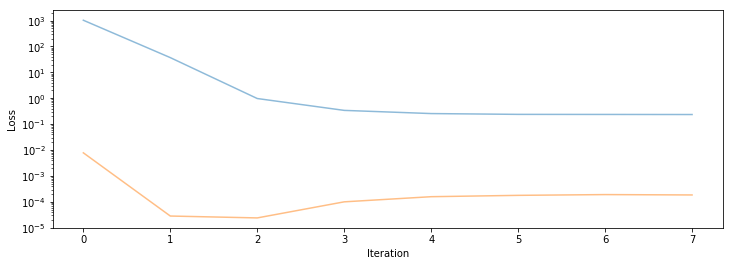

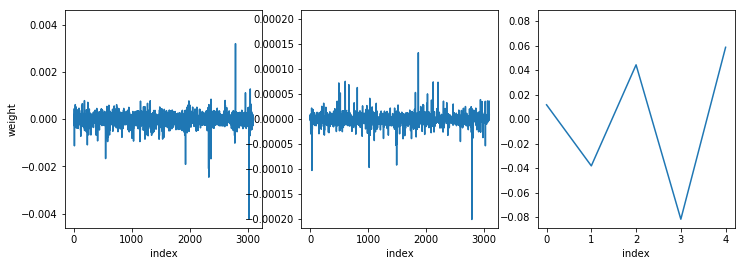

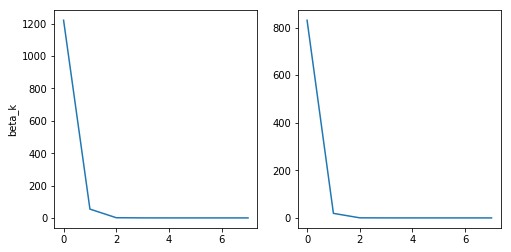

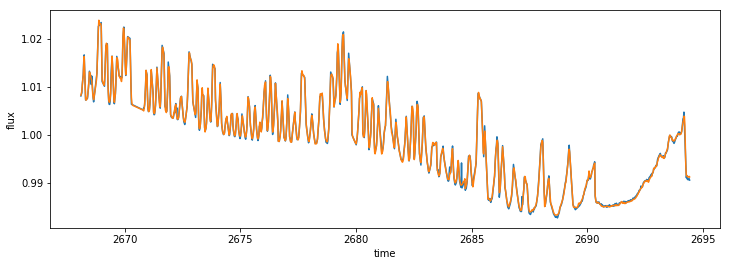

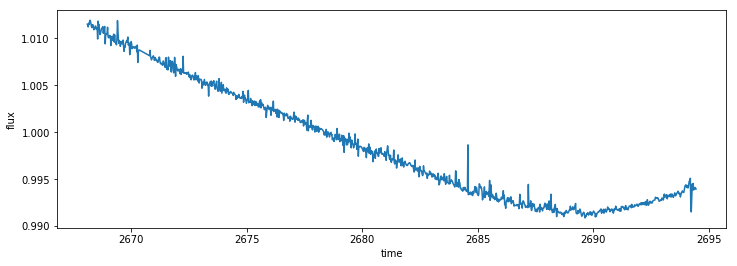

In [259]:
# De-trend just with Zé
target_lc = target_lcs[2]
wze = DetrendZe(target_lc, lam=[5e-1, 5e-1, 1e-5])

Running p, q = 0, 0
Running p, q = 0, 1
Running p, q = 0, 2
Running p, q = 0, 3
Running p, q = 0, 4
Running p, q = 1, 0
Running p, q = 1, 1
Running p, q = 1, 2
Running p, q = 1, 3
Running p, q = 1, 4
Running p, q = 2, 0
Running p, q = 2, 1
Running p, q = 2, 2
Running p, q = 2, 3
Running p, q = 2, 4
Running p, q = 3, 0
Running p, q = 3, 1
Running p, q = 3, 2
Running p, q = 3, 3
Running p, q = 3, 4
Running p, q = 4, 0
Running p, q = 4, 1
Running p, q = 4, 2
Running p, q = 4, 3
Running p, q = 4, 4
Running p, q = 5, 0
Running p, q = 5, 1
Running p, q = 5, 2
Running p, q = 5, 3
Running p, q = 5, 4


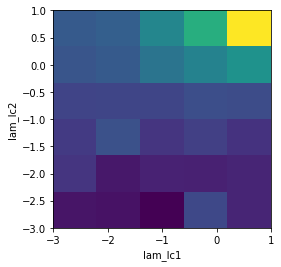

In [202]:
# Cross-validate
DetrendCV(target_lc, wze, nsteps=1000)

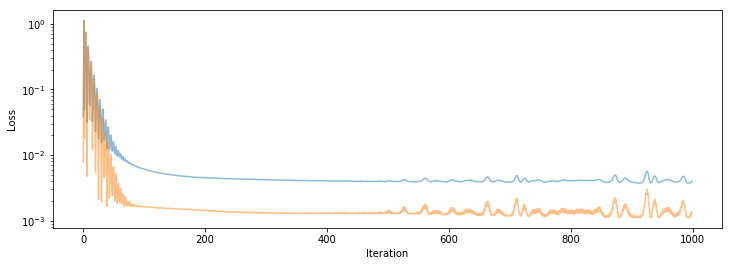

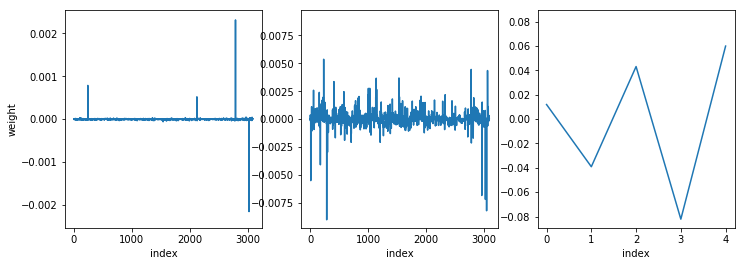

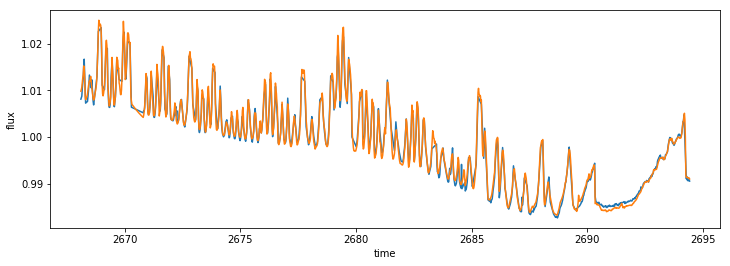

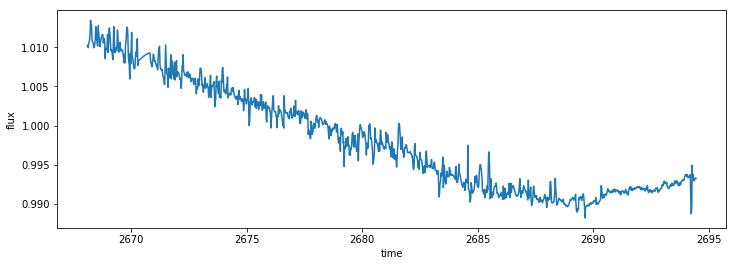

In [260]:
wadam = DetrendAdam(target_lc, wze, lam=[1e-1, 1e-3, 1e-5], nsteps=1000, lr=1e-4)

In [106]:
# De-trend with PLD
f = pyfits.open("data/c91/200000000/69000/ktwo200069870-c91_lpd-targ.fits.gz")

96325.195


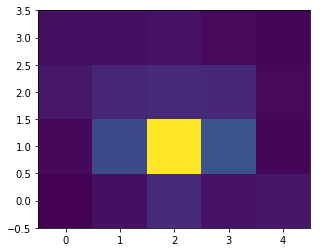

<Figure size 432x288 with 0 Axes>

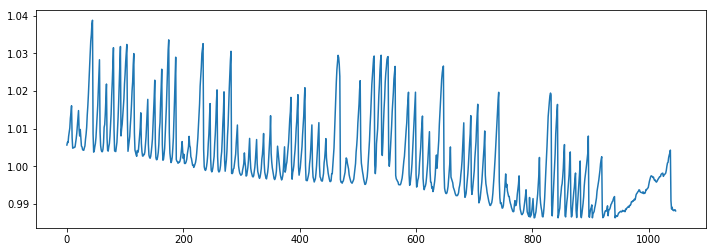

In [169]:
fig = pl.figure();
pl.imshow(f[1].data["FLUX"][0, slice(54, 58), slice(45, 50)], origin='lower');
fig = pl.figure();
fpix = f[1].data["FLUX"][:, slice(54, 58), slice(45, 50)]
fpix = np.delete(fpix, np.where(np.isnan(f[1].data["TIME"])), axis=0);
fpix = np.delete(fpix, np.where(np.sum(fpix, axis=(1,2)) < 95000), axis=0);
med = np.median(np.sum(fpix, axis=(1,2)))
print(med)
fpix /= med
flx = np.sum(fpix, axis=(1,2))
fig = pl.figure(figsize=(12, 4));
pl.plot(flx);

In [268]:
pldX = np.array(fpix.reshape(fpix.shape[0], -1))
pldX /= np.sum(pldX, axis=1).reshape(-1, 1)
pldX = np.hstack([pldX, np.vander(np.linspace(0, 1, len(flx)), N=5, increasing=True)])
XTX = np.dot(np.transpose(pldX), pldX)
XTy = np.dot(np.transpose(pldX), flx.reshape(-1,1))
weights = np.linalg.solve(XTX, XTy)
model = np.dot(pldX, weights)

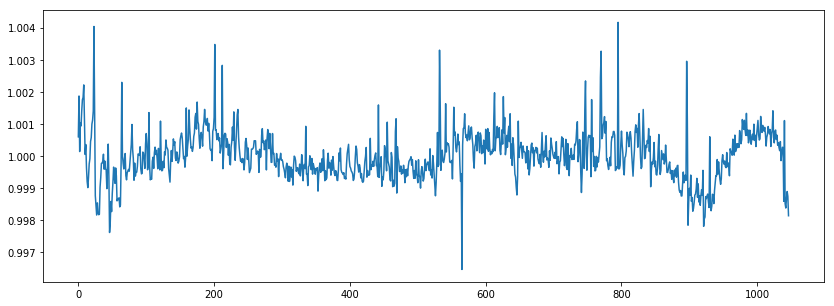

In [269]:
fig = pl.figure(figsize=(14, 5))
pl.plot(1 + flx - model.reshape(-1))